In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os

In [2]:
path = 'C:/Users/91995/Desktop/LUNG CANCER/archive (4)/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

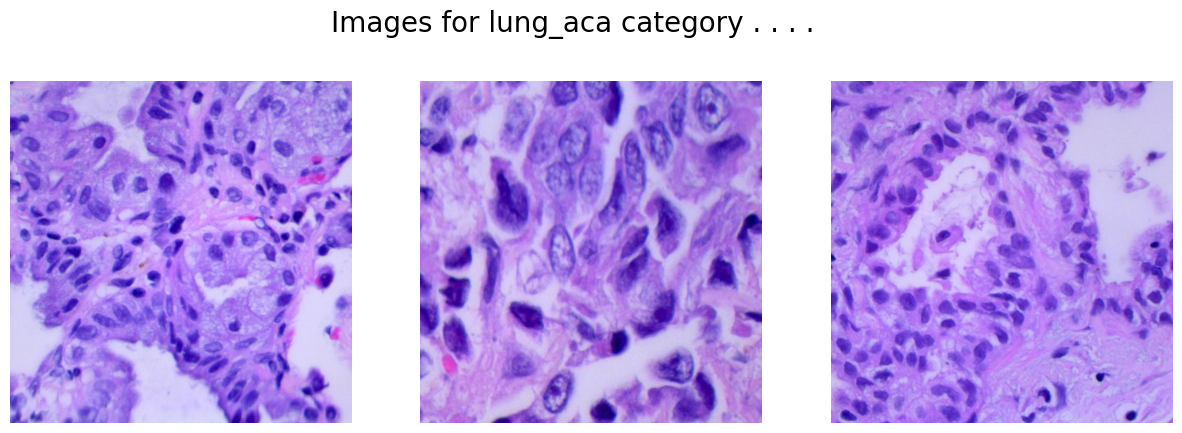

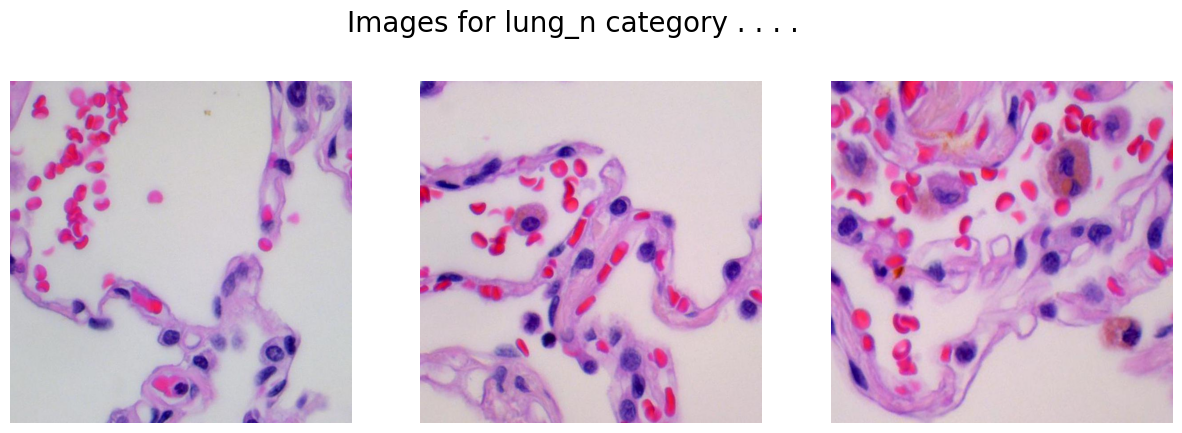

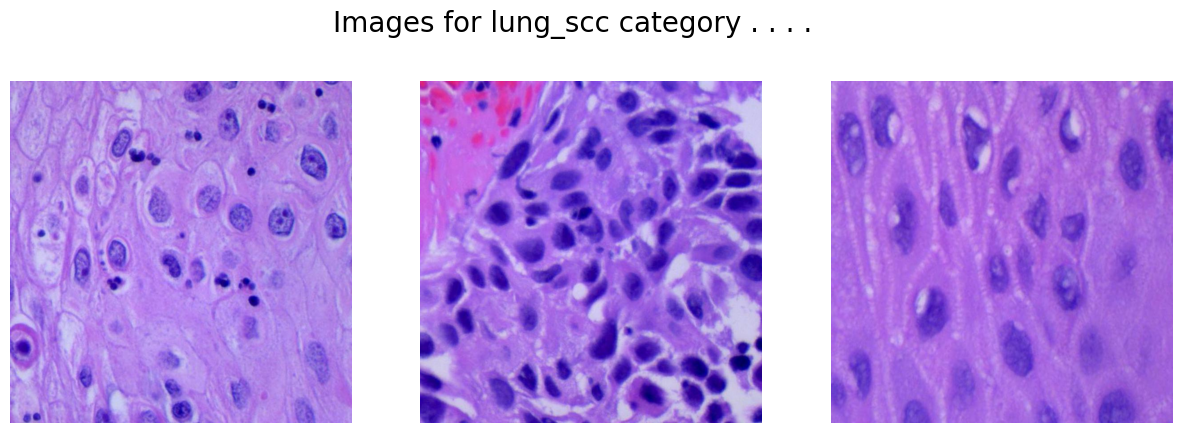

In [3]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [28]:
IMG_SIZE = 64
SPLIT = 0.2
EPOCHS = 20
BATCH_SIZE = 16

In [29]:
X=[]
Y=[]
for i,cat in enumerate(classes):
    images=glob(f'{path}/{cat}/*.jpeg')

    for image in images:
        img=cv2.imread(image)

        X.append(cv2.resize(img,(IMG_SIZE,IMG_SIZE)))
        Y.append(i)

X=np.asarray(X)
one_hot_encoded_Y=pd.get_dummies(Y).values

In [30]:
X_train,X_test,Y_train,Y_test=train_test_split(X,one_hot_encoded_Y,test_size=SPLIT,random_state=42)

In [31]:
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.2,random_state=42)

In [32]:
print(X_train.shape,X_test.shape)

(9600, 64, 64, 3) (3000, 64, 64, 3)


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout,BatchNormalization

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = Sequential([
    # Dense layer as the first layer
    Dense(256, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    
    # Convolutional layer with Batch Normalization
    Conv2D(filters=8, kernel_size=(5,5), activation='relu', padding='same'),
    Conv2D(filters=8, kernel_size=(5,5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    # Second Convolutional layer with Batch Normalization
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    # Third Convolutional layer with Batch Normalization
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    # Flatten and fully connected layers with Batch Normalization
    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    
    Dense(32, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    
    # Output layer
    Dense(3, activation='softmax')
])


In [61]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64, 64, 256)       1024      
                                                                 
 batch_normalization_24 (Bat  (None, 64, 64, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 8)         51208     
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 8)         1608      
                                                                 
 batch_normalization_25 (Bat  (None, 64, 64, 8)        32        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 8)       

In [36]:
import keras

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [62]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [63]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [64]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get('val_accuracy')>0.99:
            print('\n validation accuracy have reached upto \
                  90% so,we stop further training.')
            self.model.stop_training= True
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights= True)
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [65]:
history=model.fit(X_train,Y_train,
                  validation_data=(X_val,Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  verbose=1,
                  callbacks=[es,lr,myCallback()])

Epoch 1/20
600/600 [==============================] - 543s 902ms/step - loss: 0.3536 - accuracy: 0.8645 - val_loss: 0.3147 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 2/20
600/600 [==============================] - 542s 903ms/step - loss: 0.2479 - accuracy: 0.9070 - val_loss: 0.2047 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 3/20
600/600 [==============================] - 541s 902ms/step - loss: 0.2117 - accuracy: 0.9209 - val_loss: 0.1456 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 4/20
600/600 [==============================] - 542s 904ms/step - loss: 0.1970 - accuracy: 0.9269 - val_loss: 0.1085 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 5/20
600/600 [==============================] - 536s 893ms/step - loss: 0.1851 - accuracy: 0.9319 - val_loss: 0.1485 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 6/20
600/600 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9415
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
600/600 [========================

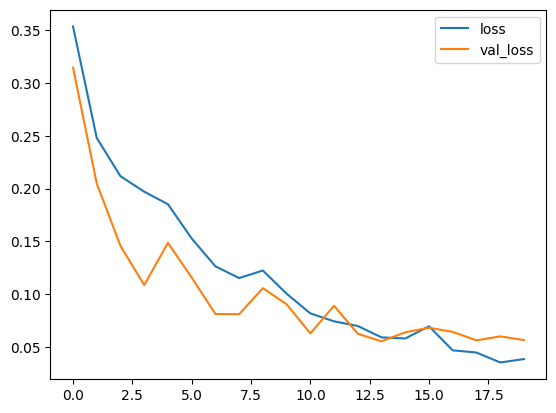

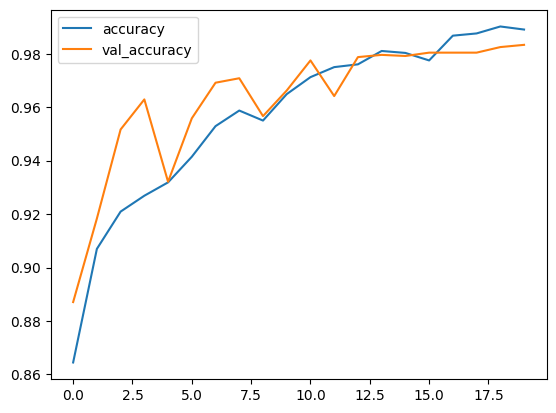

In [66]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [67]:
Y_pred = model.predict(X_test)

# Convert predictions to class labels (1D array)
Y_pred = np.argmax(Y_pred, axis=1)

# Check if Y_test is one-hot encoded
if len(Y_test.shape) > 1 and Y_test.shape[1] > 1:  # If Y_test is one-hot encoded
    Y_test = np.argmax(Y_test, axis=1)  # Convert to class labels (1D array)

94/94 [==============================] - 20s 207ms/step


In [68]:

metrics.confusion_matrix(Y_test, Y_pred)

array([[1006,    0,   31],
       [   0,  970,    0],
       [  22,    0,  971]], dtype=int64)

In [69]:




print(metrics.classification_report(Y_test, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.98      0.97      0.97      1037
      lung_n       1.00      1.00      1.00       970
    lung_scc       0.97      0.98      0.97       993

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [70]:
# Save the entire model
model.save("lung_cancer_model_extra.h5")  # Saves in HDF5 format


In [71]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model("lung_cancer_model_extra.h5")

# Verify the loaded model
loaded_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64, 64, 256)       1024      
                                                                 
 batch_normalization_24 (Bat  (None, 64, 64, 256)      1024      
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 8)         51208     
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 8)         1608      
                                                                 
 batch_normalization_25 (Bat  (None, 64, 64, 8)        32        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 8)       